In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.naive_bayes import GaussianNB , CategoricalNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [ ]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#This ia function that takes as input the actual y-values of the test set, and the probabilities that each element in the test set belongs to each 
#and every class, the function uses both values along with the number of classes to draw the ROC Plot
def plot_multiclass_roc_curve(y_test, y_probs, n_classes):
    # Binarize the output (for multi-class)
    y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#This function plots the confusion matrix which is given to it (cm), with the option to normalize it
def plot_confusion_matrix(cm, normalize=False, cmap=plt.cm.Blues):
    
    classes = ['Low', 'Medium', 'High']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, cmap=cmap, annot=True, fmt='.2f', cbar=False, square=True,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


In [ ]:
#import the csv file, and read it
file_path = 'C:/Users/youss/Downloads/green_trip_data_2017_7_clean.csv'
df2=pd.read_csv(file_path)
df = df2
#change the format to datetime format
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

# Extract only the day part
df['pickup_day'] = df['lpep_pickup_datetime'].dt.day

#change the format to datetime format
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

#  Extract only the day part
df['dropoff_day'] = df['lpep_dropoff_datetime'].dt.day

# Calculate the trip duration in seconds and store it in a new feature, (The trip duration column that exists in the dataset is calculated in a wrong manner, thats why i recalculated it)
#drop the two old features, and the incorrect ol trip_duration column
df['trip_duration_seconds'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds()

df = df.drop(columns=['lpep_dropoff_datetime','lpep_pickup_datetime','trip_duration'])

#change the format to datetime format
df['date_range'] = pd.to_datetime(df['date_range'])

# Extract only the day part
df['day_range'] = df['date_range'].dt.day
# Extract only the month part
df['month_range'] = df['date_range'].dt.month
#drop the old column
df = df.drop(columns=['date_range'])

# The following steps are to change the pickup time format to seconds only, where the day begins with second 0
#split on the ':'
df['hour'], df['minute'], df['second'] = df['pickup_time'].str.split(':').str

# Convert to integers
df['hour'] = df['hour'].astype(int)
df['minute'] = df['minute'].astype(int)
df['second'] = df['second'].astype(int)

# Convert to seconds
df['pickup_time_seconds'] = df['hour'] * 3600 + df['minute'] * 60 + df['second']
df = df.drop(columns=['hour','minute','second'])

# The following steps are to change the dropoff time format to seconds only, where the day begins with second 0
#split on the ':'
df['hour'], df['minute'], df['second'] = df['dropoff_time'].str.split(':').str

# Convert to integers
df['hour'] = df['hour'].astype(int)
df['minute'] = df['minute'].astype(int)
df['second'] = df['second'].astype(int)

# Convert to seconds
df['dropoff_time_seconds'] = df['hour'] * 3600 + df['minute'] * 60 + df['second']
df = df.drop(columns=['hour','minute','second','pickup_time','dropoff_time'])

# divide the payment level where below 10 is low labeled 0, from 10 to 50 is medium labeled 1, more than 50 is high labeled 2
df['payment_level'] = pd.cut(df['total_amount'], bins=[-float('inf'), 10, 50, float('inf')], labels=[0, 1, 2])



In [ ]:
df.head()

#The histogram shows the obvious unbalanced number of labels, where the pricey trips are much much lower than the low and medium ones
df['payment_level'].hist(bins=30, figsize=(10, 5))
plt.suptitle('Histograms of Selected Columns')
plt.show()
count_above_threshold = (df['payment_level'] == 2).sum()

df.describe()


In [ ]:
corr_matrix = df.corr()

# Extract correlation of all features with the target variable(total amount), the one we used to extract the payment level (the one to predict)
#dont worry we will drop it soon
target_corr = corr_matrix['total_amount'].drop('total_amount')
# Plotting the correlation as a bar plot
plt.figure(figsize=(10, 6))
target_corr.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Target Variable')
plt.ylabel('Correlation coefficient')
plt.xlabel('Features')
plt.show()
#df=df.drop(columns=['fare_amount'])

# As you can see there is an extremely high correlation between fare_amount and total amount, which may lead to accuracies reaching 1 in many classifiers
# although this is a dream for any machine learning engineer, because it would simplify his job alot
# this is not the case in real life, and there's no such accuracies in real life
# hwoever i will keep it and try to generalize more

# there are many poorly correlated features, we can drop them to simplify processing, but their contribution with other features can have correlation with the output which may yeild results

In [ ]:
#the label to predict is the payment lavel
y = df['payment_level']
#drop the total amount and the payment level from X
X= df.drop(columns=['payment_level','total_amount'])
# Split the data to train and test, extremely large dataset so, 0.2 for test is more than enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)


#Separate categorical and continuous columns
categorical_columns = ['passenger_count', 'payment_type', 'week_number','rate_type_JFK','rate_type_Nassau or Westchester','rate_type_Negotiated fare','rate_type_Newark','rate_type_Standard rate','vendor_VeriFone Inc.','trip_type_Street-hail','refund_neg_duplicated_True','store_and_fwd_flag_Y','pickup_day','dropoff_day','day_range','month_range','extra','mta_tax','improvement_surcharge','trip_duration_seconds','tip_amount','tolls_amount']
#i removed fare_amount for special treatment
continuous_columns = X_train.columns.difference(categorical_columns).difference(['fare_amount'])

# do standard normalization to continuous features to scale them
# also check the PCA scree plot for further implementation
# if i have powerful hardware, i would do one hot encoding to categorical Features, but ughh yeah , pray for me ( it would add lots and lots of computations) so harda b 2alily :D
# of course any transformation is fitted on training data set only, but transforming both datasets using it

# the reason why i didnt include fare_amount in the PCA is because it is again extremeley correlated nwith the output, so its information is extremely variable, PCA will make it lose some of this information
# which will affect the accuracies clearly
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Standard scale continuous columns
    ('pca', PCA(n_components=2))  # Apply PCA to continuous columns
])

categorical_transformer = Pipeline(steps=[
    ('passthrough', 'passthrough')  # Do nothing to categorical columns
])

# Combine transformers into a single ColumnTransformer
# for the fare amount column i will only scale it
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, continuous_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('fa', StandardScaler(), ['fare_amount'])
    ],
    remainder='passthrough'  # Leave all other columns unchanged
)

pca = PCA()
pca.fit(X_train[continuous_columns])

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Scree plot
# you can see that using 2 principal components i retain approximately 100% of the continuous features information, PERFECT!!
# i dont do scaling and PCA for categorical features, because they have probabilistic and descrete types of information that will get lost due to their low variance,
# i need those information for my models of course
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

# Apply transformations to the DataFrame
X_train_pp = preprocessor.fit_transform(X_train)


# transform only as i told you
X_test_pp = preprocessor.transform(X_test)







{'n_neighbors': 50}
test accuracy:  0.917664965725674
training accuracy:  0.9201270783344032


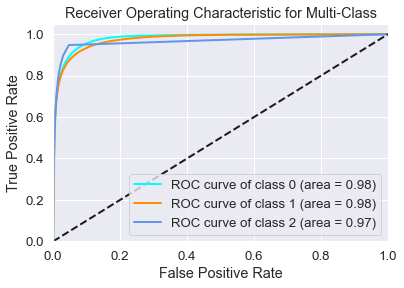

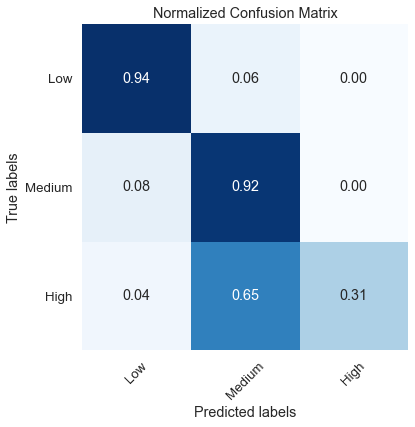

In [126]:
# Our first candidate for the day is K-NN
knn_model = KNeighborsClassifier()

# we use grid search to do both hyperparameter tuning and cross validation with five splits to give the results
# tuningg manually is such a dumb choice, thanks God for GridSearch
# i would add more parameters for tuning, but more computation power was needed, and those were okay
param_grid = {
    'n_neighbors': [50,100,200,400],
}
# applying stratified kfold is necessary due to the nature of the imbalanced data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform grid search with cross-validation to tune the hyper parameters best on the accuracy
grid_search = GridSearchCV(knn_model, param_grid, cv=stratified_kfold, scoring='accuracy',n_jobs=-1,verbose=2)
grid_search.fit(X_train_pp, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_pp)
y_train_pred=best_model.predict(X_train_pp)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

y_probs = best_model.predict_proba(X_test_pp)

print("test accuracy: ",test_accuracy)
print("training accuracy: ",train_accuracy)
plot_multiclass_roc_curve(y_test, y_probs, 3)
plot_confusion_matrix(conf_matrix,normalize=True)

# The KNN operates really poor on the 'high label', because KNN tends to operate terrible on unbalanced labels because it depends on the nearest neighbors, and most of them will not be of the small class
# the best set of hyper parameters was 50 neighbors

# the algorithm does not suffer from high variance, but can have a some bias

# ROC curves are really good

Index(['do_location', 'dropoff_time_seconds', 'pickup_time_seconds',
       'pu_location', 'trip_distance'],
      dtype='object')
test accuracy:  0.9393081623267121
training accuracy:  0.9400634844156573


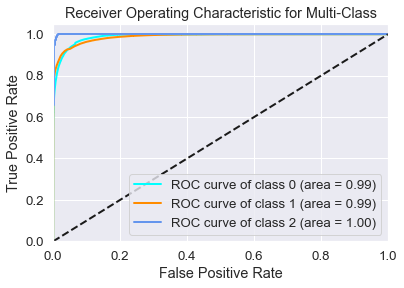

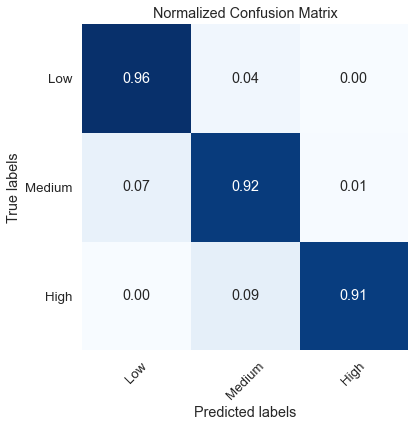

In [127]:
# concercning the naive bayes algorithm, i couldnt find any hyper parameters that i understand to tune, so i present it as it is
# however i hand tuned those two models and how to use them with which features

# i use two naive bayes models , one for the discrete features (assumed categorical) , and one with coninuos one
# using only one of those would operate badly
 
nb_model = GaussianNB()
catnb_model =CategoricalNB()
print(continuous_columns)
# Train the Model
# i fit the gaussian one on the 2 PCA features and the fare_amount only
nb_model.fit(np.concatenate((X_train_pp[:,:2],X_train_pp[:,-1:]),axis=1), y_train)
# the categorical on the rest
catnb_model.fit(X_train_pp[:,2:-1],y_train)
# Make Predictions
gnb_probs = nb_model.predict_proba(np.concatenate((X_test_pp[:,:2],X_test_pp[:,-1:]),axis=1))
cnb_probs = catnb_model.predict_proba(X_test_pp[:,2:-1])
# averaging the probabilities of both
y_probs = (gnb_probs + cnb_probs) / 2
# making final prediction
y_pred = np.argmax(y_probs, axis=1)

gnb_probs_train = nb_model.predict_proba(np.concatenate((X_train_pp[:,:2],X_train_pp[:,-1:]),axis=1))
cnb_probs_train = catnb_model.predict_proba(X_train_pp[:,2:-1])
y_probs_train = (gnb_probs_train + cnb_probs_train) / 2
y_train_pred = np.argmax(y_probs_train, axis=1)


# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


print("test accuracy: ",accuracy)
print("training accuracy: ",train_accuracy)

plot_multiclass_roc_curve(y_test, y_probs, 3)
plot_confusion_matrix(conf_matrix,normalize=True)

# the naiive bayes algorithm operated really good with good accuracy on all labels, even the ones with small number
# doesnt suffer from high variance nor high bias
# Great ROC curves as well


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\youss\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 1}
test accuracy:  0.9985162392413657
training accuracy:  0.9985969916763965


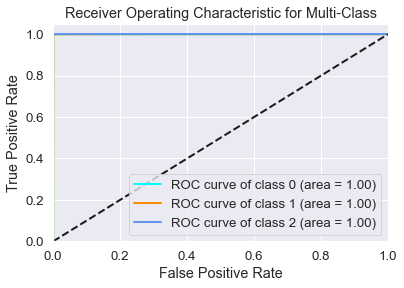

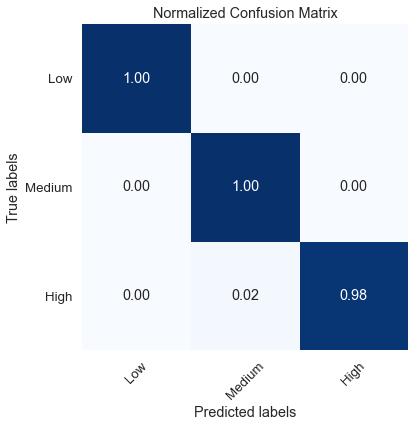

In [133]:
# Logistic regression, needed lots and lots of iterations for greater C
log_reg = LogisticRegression(max_iter=10000)
# i tune the regularization hyperparameter to prevent overfitting (L2)
param_grid = {
    'C': [0.1,1,10,20,30],
}
# Stratified for imbalanced datasets
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform grid search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=stratified_kfold, scoring='accuracy',n_jobs=-1,verbose=2)
grid_search.fit(X_train_pp, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_pp)
y_train_pred=best_model.predict(X_train_pp)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

y_probs = best_model.predict_proba(X_test_pp)

print("test accuracy: ",test_accuracy)
print("training accuracy: ",train_accuracy)
plot_multiclass_roc_curve(y_test, y_probs, 3)
plot_confusion_matrix(conf_matrix,normalize=True)

# the best hyperparameter for C is 1 
# performs insanely good  with nearly perfect classification on both sets
# however i fear from generalization if data comes from a different source , different from the source of this data. Yet it didnt overfit to the training set, as it performed as good on the test set


# low bias, low variance
# perfect ROC Curves

{'max_depth': 6, 'min_samples_leaf': 100, 'min_samples_split': 200}
test accuracy:  0.9883927202645584
training accuracy:  0.9885487145021784


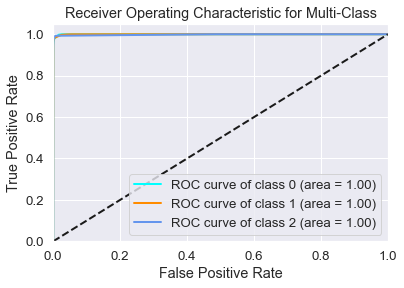

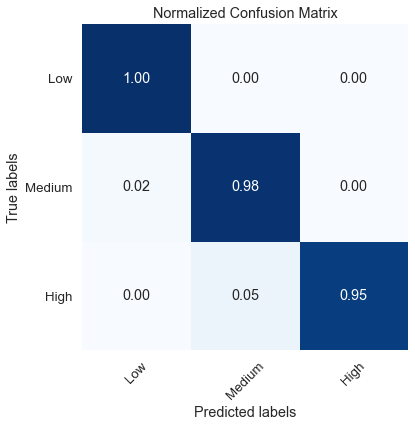

In [129]:
# Decision trees classifier
DT = DecisionTreeClassifier(random_state=46)
# the hyperparameters that i tune
param_grid = {
    'min_samples_split': [200,300,400],
    'min_samples_leaf': [100,200,300],
    'max_depth': [4,5,6]
}
#Startified sampling for imbalanced datasets
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform grid search with cross-validation
grid_search = GridSearchCV(DT, param_grid, cv=stratified_kfold, scoring='accuracy',n_jobs=-1)
grid_search.fit(X_train_pp, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_pp)
y_train_pred=best_model.predict(X_train_pp)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

y_probs = best_model.predict_proba(X_test_pp)

print("test accuracy: ",test_accuracy)
print("training accuracy: ",train_accuracy)
plot_multiclass_roc_curve(y_test, y_probs, 3)
plot_confusion_matrix(conf_matrix,normalize=True)

# produces very good results accuracy of approximately 99% and operating very good on all labels
# i could get even better results with different set of parameters (nearly 100%), but i managed to decrease it by decreasing the max depth and increasing min samples per split and leaf
# for the sake of generalizing with different data from different sources
# low bias low variance
# perfect ROC Curves

{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 50}
test accuracy:  0.9936433718052605
training accuracy:  0.9938377136850116


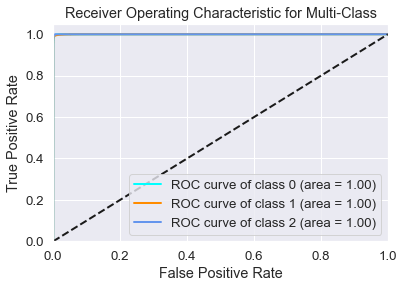

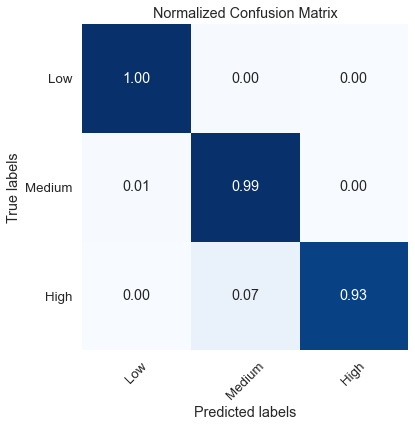

In [134]:
# Random forest classifier
clf = RandomForestClassifier( random_state=42)
# the hyper parameters i tune
# since random forests are more prune to overfitting, ididnt enforce as strict regulations as decision trees, and i was flexible with the hyper parametes
param_grid = {
     'min_samples_split': [50,100,200,300],
    'min_samples_leaf': [50,100,200,300],
    'max_depth': [6,8,10]
}
# stratified sampling  for imbalanced datasets
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=stratified_kfold, scoring='accuracy',n_jobs=-1)
grid_search.fit(X_train_pp, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_pp)
y_train_pred=best_model.predict(X_train_pp)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

y_probs = best_model.predict_proba(X_test_pp)

print("test accuracy: ",test_accuracy)
print("training accuracy: ",train_accuracy)
plot_multiclass_roc_curve(y_test, y_probs, 3)
plot_confusion_matrix(conf_matrix,normalize=True)

# the best algorithm so far , operating the best in all labels
# same fear of generalization with unknown sources of data
# extremely good ROC curves
# low bias low variance